In [1]:
import json
import numpy as np
import pandas as pd

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.models import wide_resnet50_2, regnet_y_8gf, wide_resnet101_2

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from PIL import Image
from IPython.display import clear_output
import tqdm
from tqdm.auto import tqdm

### Lets have a look at our data

In [2]:
with open('data/train_metadata.json', 'r') as file:
    js_data = json.load(file)

ids = []
categories = []
paths = []

for annotation, image in zip(js_data["annotations"], js_data["images"]):
    ids.append(image["image_id"])
    categories.append(annotation["category_id"])
    paths.append(image["file_name"])
        
df_data = pd.DataFrame({"id": ids, "category": categories, "path": paths})

df_data['path'] = 'data/'+ df_data['path']
df_data

,id,category,path
0,00000__001,0,data/000/00/00000__001.jpg
1,00000__002,0,data/000/00/00000__002.jpg
2,00000__003,0,data/000/00/00000__003.jpg
3,00000__004,0,data/000/00/00000__004.jpg
4,00000__005,0,data/000/00/00000__005.jpg
...,...,...,...
839767,15504__032,15504,data/155/04/15504__032.jpg
839768,15504__033,15504,data/155/04/15504__033.jpg
839769,15504__035,15504,data/155/04/15504__035.jpg
839770,15504__036,15504,data/155/04/15504__036.jpg


### How much examples we have in our classes?

<AxesSubplot:>

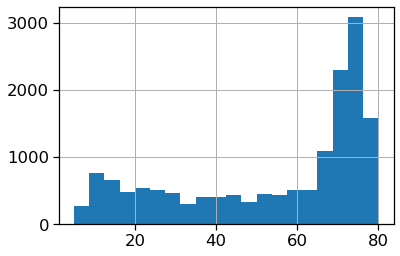

In [3]:
df_data.category.value_counts().hist(bins=20)

### For first step of experiments we use classes with a lot of samples (80)

In [4]:
test_categories = df_data.category.value_counts()[df_data.category.value_counts() == 80].index[:50]
test_data = df_data[df_data.category.apply(lambda x: x in test_categories)]
test_data = test_data.reset_index()
enc = OrdinalEncoder()
test_data = pd.concat([test_data, pd.DataFrame(enc.fit_transform(test_data.loc[:, ['category']]), dtype='int64', columns=['encodedCategory'])], axis=1)
test_data

,index,id,category,path,encodedCategory
0,6948,00123__001,123,data/001/23/00123__001.jpg,0
1,6949,00123__003,123,data/001/23/00123__003.jpg,0
2,6950,00123__004,123,data/001/23/00123__004.jpg,0
3,6951,00123__005,123,data/001/23/00123__005.jpg,0
4,6952,00123__006,123,data/001/23/00123__006.jpg,0
...,...,...,...,...,...
3995,834705,15390__099,15390,data/153/90/15390__099.jpg,49
3996,834706,15390__100,15390,data/153/90/15390__100.jpg,49
3997,834707,15390__101,15390,data/153/90/15390__101.jpg,49
3998,834708,15390__102,15390,data/153/90/15390__102.jpg,49


### Lets have a look at pictures. 

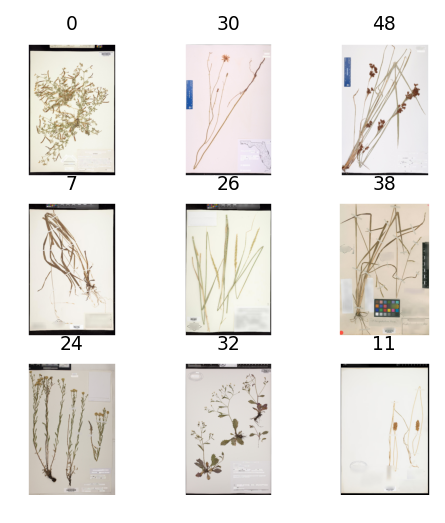

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, data_label, transform):
        self.data_dir = data_dir
        self.label = data_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.data_dir.iloc[idx]).convert('RGB')
        img = self.transform(img)
        return img, self.label.iloc[idx]
    
    def __len__(self):
        return len(self.data_dir)-1

dataSet = Dataset(test_data.path, test_data.encodedCategory, transform=T.Compose(
        [
            T.ToTensor(),         
        ]
    ))

def plot_examples(dataSet):
    fig, ax = plt.subplots(3, 3, dpi=150)
    for i in range(3):
        for j in range(3):
            tsr_img, label = dataSet[np.random.randint(len(dataSet))]
            ax[i, j].imshow(tsr_img.permute((1,2,0)))
            ax[i, j].set_title(label, fontsize=9)
            ax[i, j].set(xticks=[], yticks=[])
            for spine in ax[i, j].spines.values():
                spine.set_edgecolor('white')
            if j > 0:
                box = ax[i, j].get_position()
                ax[i, j].set_position([box.x0-0.1*j, box.y0, box.width, box.height])
plot_examples(dataSet)

### A lot of them contains garbidge data (Palettes, rulers, black lines...) at edges.  

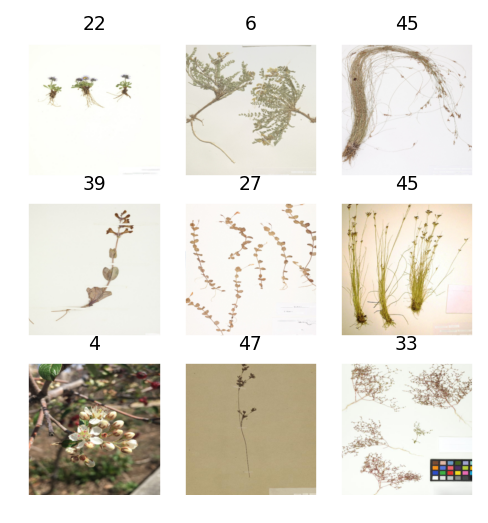

In [6]:
dataSet = Dataset(test_data.path, test_data.encodedCategory, transform=T.Compose(
        [
            T.Resize((350, 350)),
            T.CenterCrop(256),
            T.ToTensor(),         
        ]
    ))
plot_examples(dataSet)

### We will split our date into test - train group

In [7]:
X_train, X_test, y_train, y_test = train_test_split(test_data.path, test_data.encodedCategory, stratify=test_data.encodedCategory, test_size=0.2, random_state=42)

### Methods for plot, train and validate data

In [8]:
def plot_hist(accuracity, loss, n_epoch=5):
    clear_output()
    fig, ax = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
    ax[0].plot(list(range(len(accuracity[0]))), accuracity[0], '-d', label='top 1 accur')
    ax[0].plot(list(range(len(accuracity[1]))), accuracity[1], '-^', label='top 10 accur')
    
    ax[0].set_xlim(-0.13, n_epoch + 1)
    ax[0].set_ylim(-0.03, 1.05)
    ax[0].set_yticks([0, 0.25, 0.5, 0.75, 1, max(accuracity[0]), max(accuracity[1])], ['0', '', '', '', '', '{:.2f}'.format(max(accuracity[0])), '{:.2f}'.format(max(accuracity[1]))])
    ax[0].set_title('Accuracity')
    
    ax[1].plot(list(range(len(loss[0]))), loss[0], '-->', label='loss test')
    ax[1].plot(list(range(len(loss[1]))), loss[1], '-->', label='loss train')
    
    ax[1].set_xlim(-0.13, n_epoch+1)
    ax[1].set_ylim(-0.03, max(5, loss.max()))
    ax[1].set_title('Loss')
    
    fig.legend(ncol=4, bbox_to_anchor=[0.5, -0.2], loc='lower center')
    fig.savefig(f'files/{len(accuracity[0])}')
    np.save(f'files/loss.npy', loss)
    np.save(f'files/accuracity.npy', accuracity)
    plt.show()

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device)
    model.train()
    losses = np.array([])
    with tqdm(total=len(train_dataloader), file=sys.stdout, leave=False) as prbar:
        for cnt, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            prbar.update(1)
            losses = np.append(losses, loss.data.cpu().numpy())
    return losses

def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()
    model.to(device)
    losses = []
    true_classes = []
    predicted_classes = []
    with torch.no_grad():
        with tqdm(total=len(val_dataloader), file=sys.stdout, leave=False) as prbar:
            for images, labels in val_dataloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    predicted = model(images)
                    predicted_classes.append(predicted.cpu().numpy())
                    true_classes.append(labels.cpu().numpy())
                    losses.append(criterion(predicted, labels).data.cpu().numpy())
                    prbar.update(1)        
    return np.mean(np.hstack(losses)), predicted_classes, true_classes

def checkpoint(model, oprimazer, epoch, path):
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f'{path}{epoch}.pt')

def calcInfo(accuracity, losses, predicted, true, loss_test, loss_train):
    accur1 = np.array([])
    accur10 = np.array([])
    for i in range(len(predicted)):
        prarg = predicted[i].argsort()
        accur1 = np.append(accur1, np.mean(np.sum(prarg[:, -1:]  == true[i][:, np.newaxis], 1)))
        accur10 = np.append(accur10, np.mean(np.sum(prarg[:, -10:]  == true[i][:, np.newaxis], 1)))

    accuracity = np.append(accuracity, np.array([[np.mean(accur1)],
                                                [np.mean(accur10)]]), axis=1)

    losses = np.append(losses, np.array([[loss_test],
                                         [np.mean(loss_train)]]), axis=1)
    return accuracity, losses

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=5, scheduler=None):
    # model.to(device)
    
    losses = np.array([[], []])
    accuracity = np.array([[], []])
    
    for epoch in tqdm(range(n_epochs)):
        loss_train = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        checkpoint(model, optimizer, epoch, 'models/tests/reg')
        
        if (epoch + 1)%1 == 0:
            loss_test, predicted, true = predict(model, val_dataloader, criterion, device)
            accuracity, losses = calcInfo(accuracity, losses, predicted, true, loss_test, loss_train)
            
            plot_hist(accuracity, losses, n_epochs)
            print('epoch {:5d}; loss: {:7.3f} accuracy1: {:7.3f} accuracy10: {:7.3f}'.format(epoch, losses[0, -1], accuracity[0, -1], accuracity[1, -1], end=''))

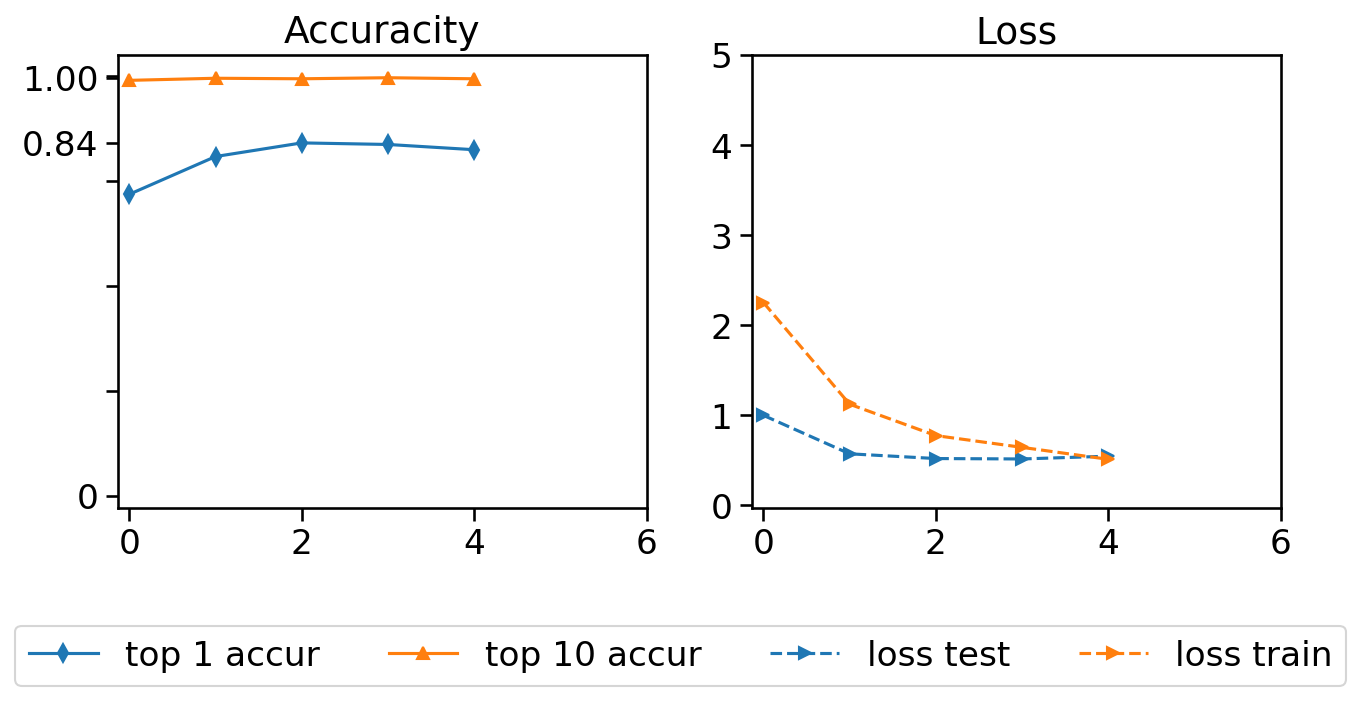

epoch     4; loss:   0.547 accuracy1:   0.825 accuracy10:   0.994


In [9]:
model = wide_resnet50_2(pretrained=True)
model.fc = nn.Linear(2048, 50)

train_dataset = Dataset(X_train, y_train, transform=T.Compose(
        [
            T.Resize((350, 350)),
            T.RandomRotation(45),
            T.RandomHorizontalFlip(0.5),
            T.CenterCrop(256),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))

val_dataset = Dataset(X_test, y_test, transform=T.Compose(
        [
            T.Resize((350, 350)),
            T.CenterCrop(256),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))


device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
criterion = nn.CrossEntropyLoss()
n_epochs = 5
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

### NNs 
## wide_resnet50_2(pretrained=False)
Tranforms:<br>
T.Resize((350, 350)),<br>
T.CenterCrop(256),<br>
T.ToTensor(),<br>
T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),<br>
<img src="pictures/first_nn.png">
## wide_resnet50_2(pretrained=True)
Optimal transforms for our data, base on experiments <br>
T.Resize((350, 350)),<br>
T.CenterCrop(256),<br>
T.RandomRotation(45),<br>
T.RandomHorizontalFlip(0.5),<br>
<img src="pictures/first_nn3.png">
More quality, low speed:<br>
T.Resize((700, 700)),<br>
T.RandomRotation(45),<br>
T.RandomHorizontalFlip(0.5),<br>
T.CenterCrop(512),<br>

<img src="pictures/first_nn4.png">

### Handle with low freq images

In [9]:
test_categories10 = df_data.category.value_counts()[df_data.category.value_counts()==10][:25]
test_categories80 = df_data.category.value_counts()[df_data.category.value_counts()==80][:25]
test_data = df_data[df_data.category.apply(lambda x: x in test_categories10 or x in test_categories80)]
test_data = test_data.reset_index()
enc = OrdinalEncoder()
test_data = pd.concat([test_data, pd.DataFrame(enc.fit_transform(test_data.loc[:, ['category']]), dtype='int64', columns=['encodedCategory'])], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(test_data.path, test_data.encodedCategory, stratify=test_data.encodedCategory, test_size=0.2, random_state=42)
train_data = pd.DataFrame({'path': X_train, 'label': y_train})

In [11]:
train8 = train_data[train_data.label.apply(lambda x: x in train_data.label.value_counts()[train_data.label.value_counts() == 8].index)]
train_data = pd.concat([train8 for _ in range(3)] + [train_data], axis=0)

In [ ]:
model = wide_resnet50_2(pretrained=True)
model.fc = nn.Linear(2048, 50)

train_dataset = Dataset(train_data.path, train_data.label, transform=T.Compose(
        [
            T.Resize((350, 350)),
            T.RandomRotation(45),
            T.RandomHorizontalFlip(0.5),
            T.CenterCrop(256),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))

val_dataset = Dataset(X_test, y_test, transform=T.Compose(
        [
            T.Resize((350, 350)),
            T.CenterCrop(256),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))


device = "cuda:0" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
criterion = nn.CrossEntropyLoss()
n_epochs = 5
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

### Without duplicate
<img src="pictures/first_nn5.png">
### 10 to 80
<img src="pictures/first_nn6.png">
### 10 to 40
<img src="pictures/first_nn7.png">

### Improve speed of reading

In [12]:
train_dataset = Dataset(test_data.path, test_data.encodedCategory, transform=T.Compose(
        [
            T.Resize((700, 700)),
            # T.RandomRotation(45),
            # T.RandomHorizontalFlip(0.5),
            # T.CenterCrop(512),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [13]:
for i in tqdm(dataloader): # it is ~ less then 2 minutes
    pass

  0%|          | 0/282 [00:00<?, ?it/s]

In [14]:
path0 = set(df_data.path.apply(lambda x: 'fast_'+'/'.join(x.split('/')[:-2])).values)
path1 = set(df_data.path.apply(lambda x: 'fast_'+'/'.join(x.split('/')[:-1])).values)
# for k in path0, path1:
#     for i in k:
#         os.mkdir(i)

In [15]:
test_data['fastDataPath'] = test_data.path.apply(lambda x: 'fast_'+ x[:-4]+'.pt')
test_data

,index,id,category,path,encodedCategory,fastDataPath
0,8026,00142__001,142,data/001/42/00142__001.jpg,0,fast_data/001/42/00142__001.pt
1,8027,00142__002,142,data/001/42/00142__002.jpg,0,fast_data/001/42/00142__002.pt
2,8028,00142__003,142,data/001/42/00142__003.jpg,0,fast_data/001/42/00142__003.pt
3,8029,00142__004,142,data/001/42/00142__004.jpg,0,fast_data/001/42/00142__004.pt
4,8030,00142__005,142,data/001/42/00142__005.jpg,0,fast_data/001/42/00142__005.pt
...,...,...,...,...,...,...
2245,839033,15490__009,15490,data/154/90/15490__009.jpg,49,fast_data/154/90/15490__009.pt
2246,839034,15490__010,15490,data/154/90/15490__010.jpg,49,fast_data/154/90/15490__010.pt
2247,839035,15490__011,15490,data/154/90/15490__011.jpg,49,fast_data/154/90/15490__011.pt
2248,839036,15490__012,15490,data/154/90/15490__012.jpg,49,fast_data/154/90/15490__012.pt


In [16]:
train_dataset = Dataset(test_data.path, test_data.fastDataPath, transform=T.Compose(
        [
            T.Resize((700, 700)),
            T.ToTensor(),
            T.Normalize((0.7620, 0.7378, 0.6874), (0.2438, 0.2486, 0.2546)),
        ]
    ))
for img, pth in tqdm(train_dataset): 
    torch.save(img, pth)

  0%|          | 0/2249 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


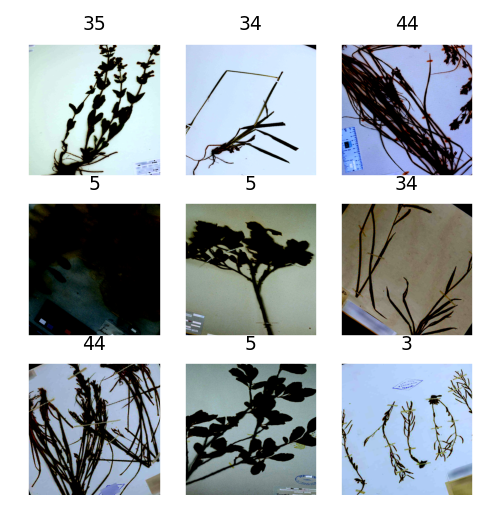

In [19]:
class FastDataset(Dataset):   
    def __getitem__(self, idx):
        img = torch.load(self.data_dir.iloc[idx])
        img = self.transform(img)
        return img, self.label.iloc[idx]
    
    def __len__(self):
        return len(self.data_dir)-1
    
fast_dataset = FastDataset(test_data.fastDataPath, test_data.encodedCategory, transform=T.Compose(
        [
            # T.ToTensor(),
            T.RandomRotation(45),
            T.RandomHorizontalFlip(0.5),
            T.CenterCrop(512),
        ]
    ))
plot_examples(fast_dataset)

In [21]:
dataloader = torch.utils.data.DataLoader(fast_dataset, batch_size=8, shuffle=True)
for cnt, i in enumerate(tqdm(dataloader)):
    if cnt == 10:
        break
# bad idea... ~4 minutes...

  0%|          | 0/282 [00:00<?, ?it/s]